<IPython.core.display.Javascript object>


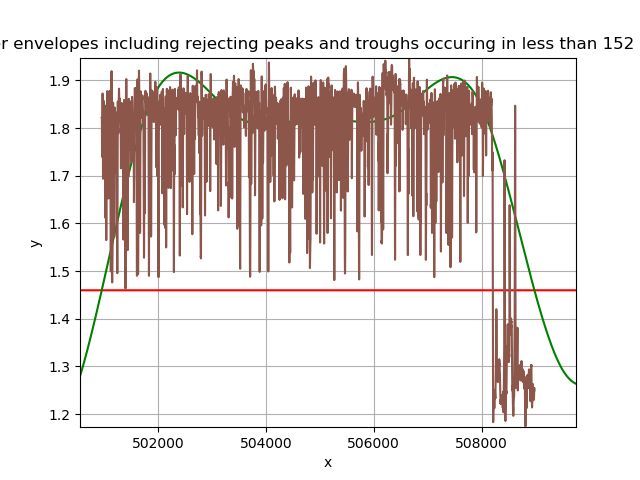

In [14]:
import numpy as np
from numpy import array, sign, zeros
import scipy as sp
from scipy import signal
from scipy import io
from statistics import mean
from scipy.interpolate import interp1d
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot,show,grid, xlabel, ylabel, title, figure
from nptdms import TdmsFile
import pandas as pd
import sys
#import mpld3
#mpld3.enable_notebook()
%matplotlib notebook
#plt.rcParams['agg.path.chunksize'] = 1000000


def getEnvelopeModels(aTimeSeries, rejectCloserThan = 0):   
    '''Fits models to the upper and lower envelope peaks and troughs.
    
    A peak is defined as a region where the slope transits from positive to negative (i.e. local maximum).
    A trough is defined as a region where the slope transits from negative to positive (i.e. local minimum).
    
    This example uses cubic splines as models.
    
    Parameters:
    
    aTimeSeries:      A 1 dimensional vector (a list-like).
    rejectCloserThan: An integer denoting the least distance between successive peaks / troughs. Or None to keep all.
    '''    
    #Prepend the first value of (s) to the interpolating values. This forces the model to use the same starting point for both the upper and lower envelope models.    
    u_x = [0,]
    u_y = [aTimeSeries[0],]    
    lastPeak = 0;
    
    l_x = [0,]
    l_y = [aTimeSeries[0],]
    lastTrough = 0;
    
    #Detect peaks and troughs and mark their location in u_x,u_y,l_x,l_y respectively.    
    for k in range(1,len(aTimeSeries)-1):
        #Mark peaks        
        if (sign(aTimeSeries[k]-aTimeSeries[k-1])==1) and (sign(aTimeSeries[k]-aTimeSeries[k+1])==1) and ((k-lastPeak)>rejectCloserThan):
            u_x.append(k)
            u_y.append(aTimeSeries[k])    
            lastPeak = k;
            
        #Mark troughs
        if (sign(aTimeSeries[k]-aTimeSeries[k-1])==-1) and ((sign(aTimeSeries[k]-aTimeSeries[k+1]))==-1) and ((k-lastTrough)>rejectCloserThan):
            l_x.append(k)
            l_y.append(aTimeSeries[k])
            lastTrough = k
    
    #Append the last value of (s) to the interpolating values. This forces the model to use the same ending point for both the upper and lower envelope models.    
    u_x.append(len(aTimeSeries)-1)
    u_y.append(aTimeSeries[-1])
    
    l_x.append(len(aTimeSeries)-1)
    l_y.append(aTimeSeries[-1])
    
    #Fit suitable models to the data. Here cubic splines.    
    u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
    l_p = interp1d(l_x,l_y,kind = 'cubic',bounds_error = False, fill_value=0.0)
    
    return (u_p,l_p)


###############################################################################################\n",
###############################################################################################\n",
###############################################################################################\n",
###############################################################################################\n",

#LOADING THE TDMS FILE

#num_to_plot = 2
    
#for i in range(1,num_to_plot):

tdms_file = TdmsFile("G3G4_SHBiotin_SA_phi29_Temp_dNTP_Mg_50mV_1.tdms")
tdms_groups = tdms_file.groups()
attributes = tdms_file.object().properties 
tdms_0 = tdms_file.group_channels("Untitled")
tdms_1 = tdms_file.group_channels("Untitled")
Group_Channel_0_1 = tdms_file.object('Untitled', 'Current (nA)')
Group_Channel_data_0_1 = Group_Channel_0_1.data
Group_Channel_1_1 = tdms_file.object('Untitled', 'Time (s)')
Group_Channel_data_1_1 = Group_Channel_1_1.data
Group_Channel_Current = (Group_Channel_data_0_1)
#print("shape of GCC", Group_Channel_Current.shape)
X= Group_Channel_data_1_1
Y= Group_Channel_Current
#x = np.linspace(0,Group_Channel_Current.shape[0],Group_Channel_Current.shape[0]  )*(1/50000)
#plt.plot(X,Y)
#plt.savefig("Raw_Signal_G3G4_SHBiotin_SA_phi29_Temp_dNTP_Mg_50mV_(%s).png"%i, bbox_inches="tight", dpi=600)
#plt.show()
#narr_curr = np.column_stack((x, Group_Channel_Current))
#io.savemat("Raw_Signal_G3G4_SHBiotin_SA_phi29_Temp_dNTP_Mg_50mV_(%s).mat"%i, {"array": narr_curr})
#plt.close()  
    
#### Hilbert transform- Lower envelope of raw data ####
    
s = Y
z=len(s)
#Estimate models without rejecting any peak
P = getEnvelopeModels(s,z/1000)        
#Evaluate each model over the domain of (s)
#q_u = map(P[0],xrange(0,len(s)))
q_l = list(map(P[1],np.arange(0,len(s))))   
t = []
x = 1.459663551
for i in range(0,z):
    t.append(x)
#Plot everything
plot(t, 'r');plot(q_l,'g');xlabel('x');ylabel('y');title('Upper and lower envelopes including rejecting peaks and troughs occuring in less than 152 samples distance');grid(True);show();
    
#Estimate models by rejecting peaks and troughs that occur in less than 5 samples distance    
#P = getEnvelopeModels(s,5)        
#Evaluate each model over the domain of (s)
#q_u = map(P[0],xrange(0,len(s)))
#q_l = map(P[1],xrange(0,len(s)))        
    
#Plot everything    
#figure();    
#plot(s);xlabel('x');ylabel('y');title('Upper and lower envelopes including rejecting peaks and troughs occuring in less than 5 samples distance');hold(True);plot(q_u,'r');plot(q_l,'g');grid(True);show()


In [23]:
#### Square wave -Thresholding to convert lower envelope to 0-1 square wave ####

lower_envelope = np.asarray(q_l)
l= lower_envelope.shape[0]
print(l)
#def moving_average(x,w):
#    return np.convolve(x,np.ones(w),'valid')/w
#window=int(round((l/50000)*1000))
#mov_curr= moving_average(lower_envelope,window)
#avg_curr= mean(lower_envelope)
print(np.max(lower_envelope))
print(np.min(lower_envelope))
threshold= 0.75*(np.max(lower_envelope))
print(threshold)
temp=[]
## zero is open polymerase, looking for dntp ## 
## one is closed polymerase, matching the found dntp with the complementary base in the template ##


            
for j in range (l):
    if lower_envelope[j]>=threshold:
        temp.append(1)
    else:
        temp.append(0)
print(len(temp))
#Y_new=np.asarray(temp)*(-1)
plt.plot(X,temp)
plt.show()
#plt.savefig("State_closed_&_open_G3G4_SHBiotin_SA_phi29_Temp_dNTP_Mg_50mV_(%s).png"%i, bbox_inches="tight", dpi=600)
#plt.close()

1515026
1.9462180680263559
1.128175999431642
1.4596635510197669
1515026


In [24]:
####Exact time steps - Use '1' step to append time steps of good clips to excel file####

temp_1 = []
temp_0 = []

count_1 = 0
count_0 = 0
for k in range(0,len(temp)):
    if temp[k] == 1:
        if (k<len(temp)-1):
            if(temp[k+1]!=0):
                count_1 += 1
            elif(temp[k] == 1 and temp[k+1]==0):
                print('count 1',count_1)
                temp_1.append(count_1)
                count_1 = 0
        elif(k==len(temp)):
            temp_1.append(1)
    else:
        if(k<len(temp)-1):
            if(temp[k+1]!=1):
                count_0 +=1
            elif(temp[k] == 0 and temp[k+1]==1):
                print('count 0',count_0)
                temp_0.append(count_0)
                count_0 = 0
        elif(k==len(temp)):
            temp_0.append(0)        
            
    #print(count_1) 

print("temp1", (temp_1))
print("temp0", (temp_0)) 

merged_list = []
for i in range(len(temp_1)):
    merged_list.append(temp_0[i])
    merged_list.append(temp_1[i])
    
print(merged_list)

count 0 500961
count 1 8012
count 0 8791
count 1 7782
count 0 1395
count 1 9338
count 0 100097
count 1 2104
count 0 49344
count 1 5071
count 0 76160
count 1 998
count 0 124616
count 1 1977
count 0 17529
count 1 24985
count 0 341805
count 1 5184
count 0 16264
count 1 30580
count 0 62172
count 1 451
temp1 [8012, 7782, 9338, 2104, 5071, 998, 1977, 24985, 5184, 30580, 451]
temp0 [500961, 8791, 1395, 100097, 49344, 76160, 124616, 17529, 341805, 16264, 62172]


In [37]:
####Exact current amplitudes- Find current amplitudes of the good clip time steps and add to the excel file of that clip####
final_list = []
final_list_curr = []

for i in range(len(merged_list)):
    if i % 2 != 0:
        if merged_list[i] >= 3000:
            val = merged_list[0:i]
            sum_val = np.sum(val)
            final_list.append([(sum_val +1)/50000.0, (sum_val + merged_list[i]+1) /50000.0])
            final_list_curr.append([(sum_val +1), (sum_val + merged_list[i]+1)])
            
print(final_list)

import pandas as pd
for i in range(len(final_list)):
    start, end = final_list_curr[i]
    curr_val = Y[start:end]
    x_val = np.arange(start,end)
    x_val = x_val / 50000 
    df = pd.DataFrame({'col1':x_val, 'col2':curr_val})
    df.to_csv('clip_%s.csv'%(i+1), index=False)

[[10.01924, 10.17948], [10.3553, 10.51094], [10.53884, 10.7256], [13.7565, 13.85792], [18.28352, 18.78322], [25.61932, 25.723], [26.04828, 26.65988]]
